# Восстановление золота

## Описание проекта

Необходимо Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Описание данных
**Технологический процесс**

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

## Оглавление
1. Подготовка данных
2. Анализ данных
3. Построение моделей

In [1]:
# Блок импорта
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Блок Phik корреляции
import phik
from phik.report import plot_correlation_matrix
from phik import report

# Блок ошибок
import warnings
warnings.filterwarnings('ignore')

# Подготовка моделей
from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score

# метрики
from sklearn.metrics import mean_absolute_error

# модели
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [2]:
#sns.set(style="darkgrid")

# Подготовка данных

In [3]:
try:
    df_train = pd.read_csv('gold_recovery_train_new.csv')
    df_test = pd.read_csv('gold_recovery_test_new.csv')
    df_full = pd.read_csv('gold_recovery_full_new.csv')
except FileNotFoundError:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

In [4]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [6]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


## Промежуточный вывод
- Некоторые признаки содержат некоторое количество пропусков. В будущей необходимо с ними разобраться.
- Обучающая выборка содержет целевые признаки, необходимо из оттуда изьять, чтобы обучение моделей машинного обучения было корректным.

In [8]:
df_train.duplicated().sum()

0

In [9]:
df_test.duplicated().sum()

0

In [10]:
df_full.duplicated().sum()

0

Отлично дубликатов в данных не обнаружено!

In [11]:
#fig, ax = plt.subplots(figsize=(40,40))
#sns.heatmap(df_train.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax);

In [12]:
#fig, ax = plt.subplots(figsize=(40,40))
#sns.heatmap(df_test.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax);

In [13]:
#fig, ax = plt.subplots(figsize=(40,40))
#sns.heatmap(df_full.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax);

In [14]:
#phik_overview = df_train.phik_matrix();
#plot_correlation_matrix(phik_overview.values, 
#                        x_labels=phik_overview.columns, 
#                        y_labels=phik_overview.index, 
#                        vmin=-1, vmax=1, color_map="Greens", 
#                        title=r"correlation $\phi_K$", 
#                        figsize=(40, 40));
#plt.tight_layout()

In [15]:
#phik_overview = df_test.phik_matrix();
#plot_correlation_matrix(phik_overview.values, 
#                        x_labels=phik_overview.columns, 
#                        y_labels=phik_overview.index, 
#                        vmin=-1, vmax=1, color_map="Greens", 
#                        title=r"correlation $\phi_K$", 
#                        figsize=(40, 40));
#plt.tight_layout()

In [16]:
#phik_overview = df_full.phik_matrix();
#plot_correlation_matrix(phik_overview.values, 
#                        x_labels=phik_overview.columns, 
#                        y_labels=phik_overview.index, 
#                        vmin=-1, vmax=1, color_map="Greens", 
#                        title=r"correlation $\phi_K$", 
#                        figsize=(40, 40));
#plt.tight_layout()

## Промеужточный вывод
На тепловых картах выдны явные и заномерные очяги корреляций признаков, которые по обусловлены технологическим процессам восстановления золота.\
Корреляция Phik явных расхождений с корреляцией Пирсона не обнаружила.\
Явных аномалий не обнаружено.

## Расчёт эффективности

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.\
Эффективность обогащения рассчитывается по формуле:

![title](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

где:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах.\
Причём важен не только финальный продукт, но и черновой концентрат.

In [17]:
# Сосздадим функцию, чтобы проверить, что эффективность обогащения рассчитана правильно
def calculate_recovery(C, F, T):
    return ((C * (F - T)) / (F * (C - T))) * 100

def calculate_recovery_df(df):
    C = df['rougher.output.concentrate_au']
    F = df['rougher.input.feed_au']
    T = df['rougher.output.tail_au']
    
    return calculate_recovery(C, F, T)

In [18]:
# Оставим только те признаки, которые нужны для рассчетов и сравнений
columns = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']
df_train_for_check = df_train[columns]
df_train_for_check = df_train_for_check.dropna()

In [19]:
df_train_for_check['rougher.output.recovery_calculated'] = df_train_for_check.apply(calculate_recovery_df, axis=1)
mae = mean_absolute_error(df_train_for_check['rougher.output.recovery'], df_train_for_check['rougher.output.recovery_calculated'])
mae

9.73512347450521e-15

### Промежуточный вывод
- Средняя квадратичная ошибка в расчетах стримится к нулю, что готовит о верности проведенных расчетов обогащения.
- Было принято решение удалить пропуски из тренировочного датасета с целью повышения качества рассчетов эффективности обогащения и невозмоностью корректно заполнить сырые пропущенные данные.

In [20]:
# Проанализируем признаки, недоступные в тестовой выборке.
columns_exclude = set(df_train.columns) - set(df_test.columns)
columns_exclude

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

## Промежуточный вывод
Недостающие признаки являются либо вычисляемыми значениями, либо итоговым результатов обогащения золота, недоступного нам на начальном этапе работы моделей машинного обучения. Это означает, что мы не может корректно учить на ним наши модели, остается опперировать только теми параметрами, которые поступают с датчиков.

Так как нам было сказано, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.\
Логичным выглядит решение заменить существующие индексы в датасетах на данные признака date. Таким образом мы в явном виде свяжем все три датасета

In [21]:
df_test = df_test.set_index('date')
df_train = df_train.set_index('date')
df_full = df_full.set_index('date')

In [22]:
# Для начала оставим в обучающей выборке только те, что есть в тесте
df_train_selected = df_train[df_test.columns]

In [23]:
# Посмотрим пример пустых значений
df_train_selected[df_train_selected['rougher.input.floatbank10_sulfate'].isnull()].head(10)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-19 02:00:00,15.273131,1.940663,7.25,0.180119,1546.951271,-501.138590,1550.530280,-500.130616,1551.535239,-502.251161,...,13.947368,-703.993293,12.018188,-559.800324,9.999754,-512.673353,7.946763,-500.475471,11.963962,-607.847547
2016-01-21 10:00:00,NaN,NaN,7.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-18 14:59:59,62.830953,7.006670,8.21,0.574743,1601.946035,-500.703455,1607.720913,-500.257229,1603.724847,-499.778935,...,15.012221,-401.688850,4.974202,-400.312056,10.051200,-403.969189,5.039952,-400.190704,23.012079,-501.597792
2017-03-17 07:59:59,24.767205,2.364825,7.56,0.527468,1697.727385,-498.917662,1735.961103,-497.238807,1805.749310,-491.749232,...,24.980761,-399.656696,22.969908,-399.919751,21.143900,-446.837072,19.988989,-449.639572,24.976754,-500.298335
2017-07-13 20:59:59,40.010587,2.198810,5.31,0.444120,1716.936799,-499.521654,1638.357032,-499.019164,1752.317852,-499.104018,...,21.935676,-500.545499,15.002559,-379.946634,17.995937,-501.723754,13.016940,-499.933589,14.984270,-499.646788
2017-07-13 21:59:59,38.886104,2.463417,5.31,0.401628,1721.863756,-499.620341,1643.557333,-499.578518,1749.974498,-500.069786,...,21.973990,-499.813137,15.019052,-379.948561,17.979945,-498.066453,12.973337,-500.005190,15.009571,-500.676274
2017-07-13 22:59:59,34.976736,2.478461,5.31,0.400812,1718.714360,-499.979472,1646.186641,-500.014574,1749.843203,-499.936938,...,22.041849,-500.850434,14.970518,-379.562828,17.942420,-500.552558,12.999058,-499.960012,14.996107,-499.999168
2017-07-13 23:59:59,36.060204,2.461853,5.31,0.392639,1715.775841,-499.566793,1650.106583,-499.052045,1749.423858,-500.072068,...,21.929310,-500.343037,14.997039,-380.634927,18.017391,-498.388066,13.006461,-499.943992,15.006577,-499.986136
2017-07-14 00:59:59,29.991646,2.479250,5.31,0.345743,1726.133095,-499.253863,1659.365246,-502.046199,1750.948688,-499.194336,...,22.039184,-500.387232,15.066163,-379.994082,17.939576,-500.320034,13.037536,-499.781496,14.998483,-499.183164


Несмотря на утверждение составителей датасета о схожести считываемых данных в соседние временные отрезки это не всегда является правдой.

Для большей сохранности и исключения непоправимых искажений нашего исследования создадим два датасета. В первом удалим все пропущенные значения, а во втором применим метод заполнения `ffill` который заполняет пропущенные значения соседними непропущенными.

In [24]:
df_train_selected_fill = df_train_selected.fillna(method='ffill')
df_train_selected_drop = df_train_selected.dropna()

In [25]:
# сделаем это и для итоговой выборки
df_full_drop = df_full.dropna()
df_full_fill = df_full.fillna(method='ffill')

## Вывод по подготовке данных
- Данные были изучены, проверены на предмет наличия дубликатов.
- Проверили корректность расчетов эффективности обогащения.
- Проведена предобработка данных, частично устранены пропуски значений (не забываем, что мы до конца не уверены в корректности метода заполнения пропусков и предусмотрели пути отхода).
- Связали все три датасета, заменив индексы на время регистрации признаков (колонка признака `date`).
- Оставили в обучающей выборке только те признаки, на которых корректно будет проводит обучение.

# Анализ данных

## Изменение концентраций металлов (Au, Ag, Pb) на различных этапах очистки

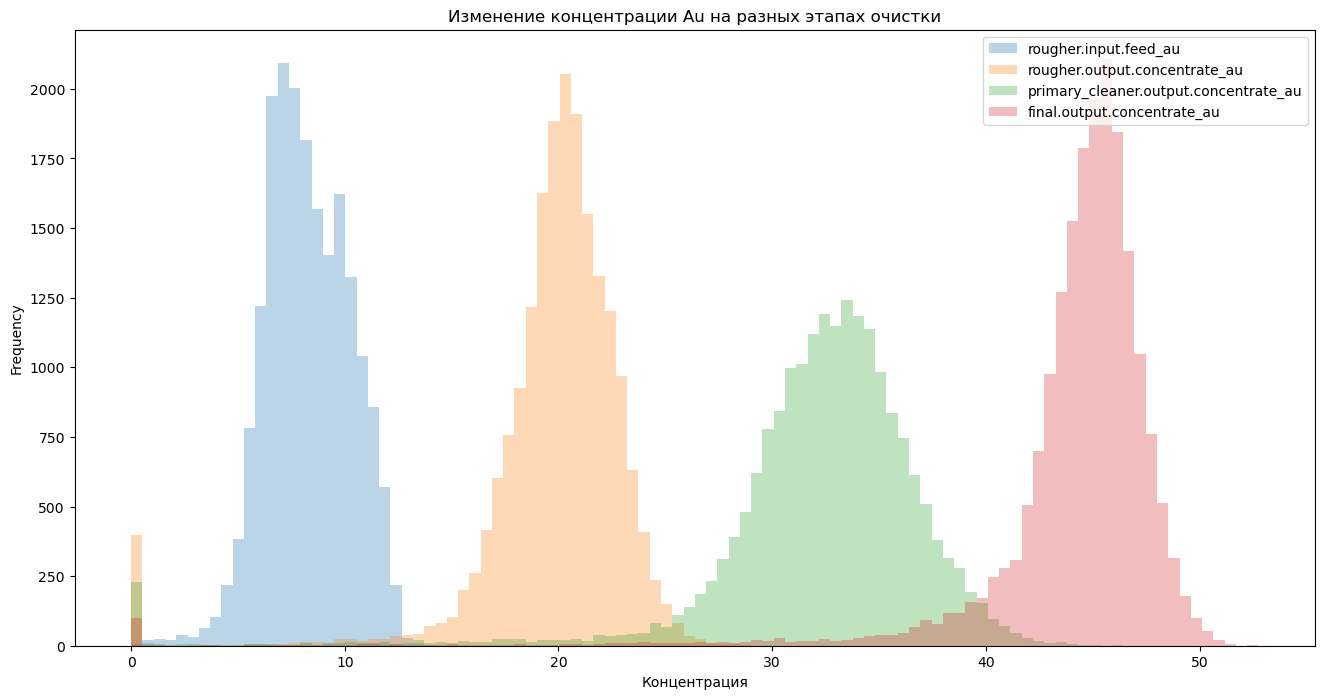

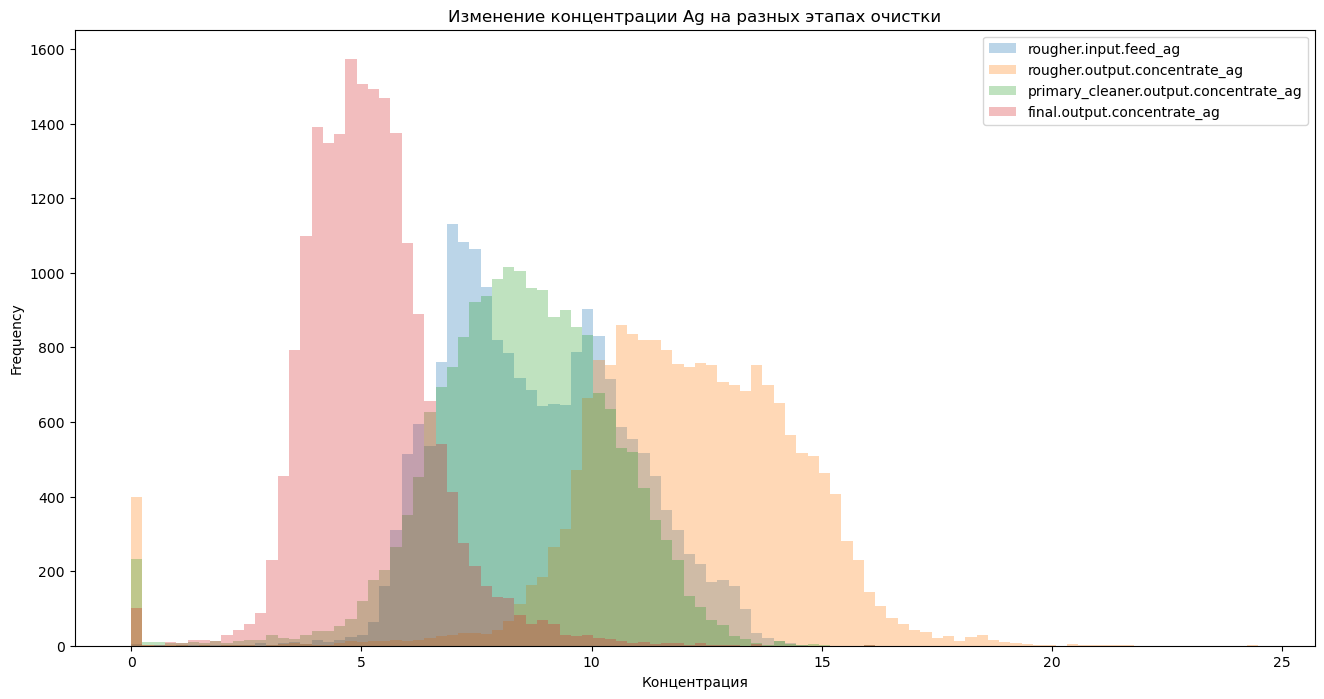

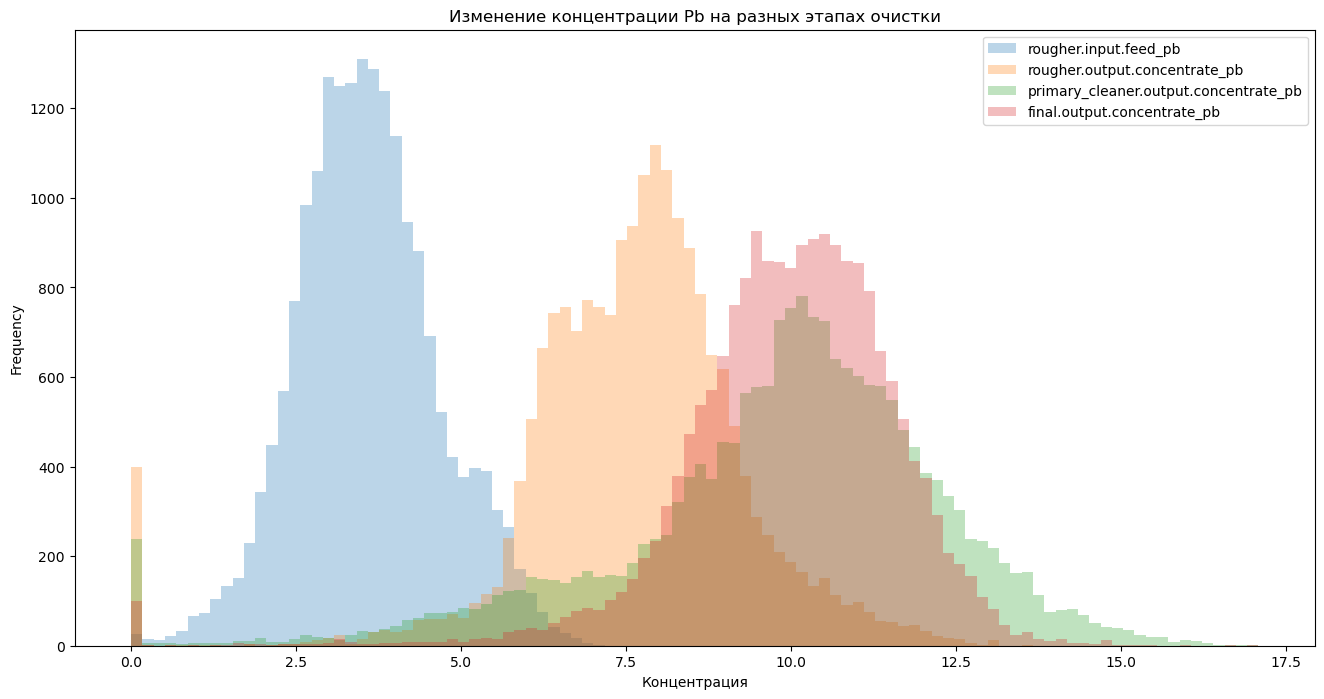

In [26]:
ag_list = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
au_list = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au','final.output.concentrate_au']
pb_list = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']

metall_dict = {"Au": au_list, "Ag": ag_list, "Pb": pb_list}
for key in metall_dict:
    title = 'Изменение концентрации ' + key + ' на разных этапах очистки'
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Концентрация')
    ax.set_ylabel('Частота')

    df_full_fill[metall_dict[key]].plot(kind='hist', bins=100, figsize=(16,8), ax=ax, legend=True, alpha=0.3);

### Промежуточный вывод
- Было бы странным увидеть что-то иное, но с каждым этапом очистки концентрация золота в веществе возрастает.
- Концентрация серебра напротив уменьшается с каждым этапом (из школьного курса по химии помню, что серебро является отличным катализатором процессов и чем меньше остается невыделенного золота в концетрате, тем больше серебра уже отработало, всё логично).
- Концетрация свинца растет и с каждым этапом разброс значений его концетрации в растворе уменьшается.
- Есть неопознанные выбросы на нулевом значении концетрации всех веществ, частота появления которых ещё и уменьшается с каждым этапом.
- Интересен тот факт, что в поступающий(изначальных) данных выбросы на нулевом значении отсутвутвуют.

## Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

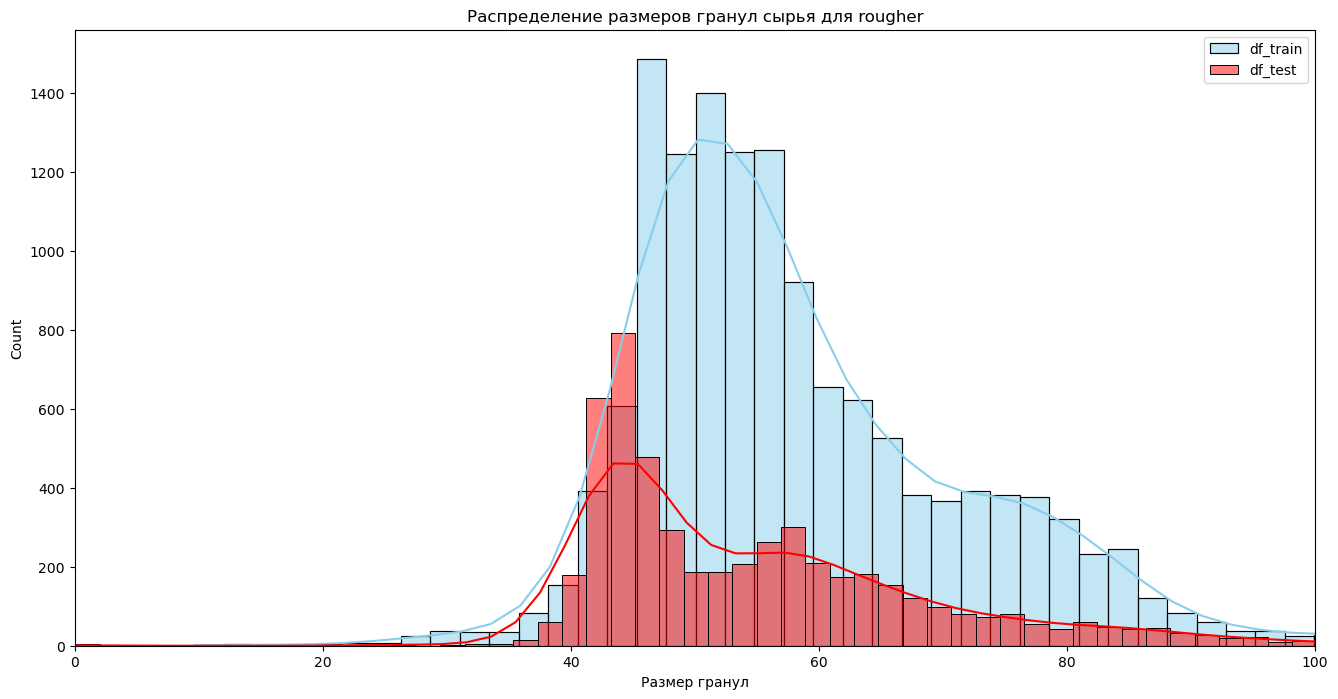

In [27]:
fig, ax = plt.subplots()
ax.set_title('Распределение размеров гранул сырья для rougher')
ax.set_xlabel('Размер гранул')
ax.set_xlim(0,100);

sns.histplot(data=df_train_selected_fill, x="rougher.input.feed_size", color="skyblue", label="df_train", kde=True, bins=200)
sns.histplot(data=df_test, x="rougher.input.feed_size", color="red", label="df_test", kde=True, bins=200)

fig.set_figheight(8)
fig.set_figwidth(16)
plt.legend() 
plt.show()

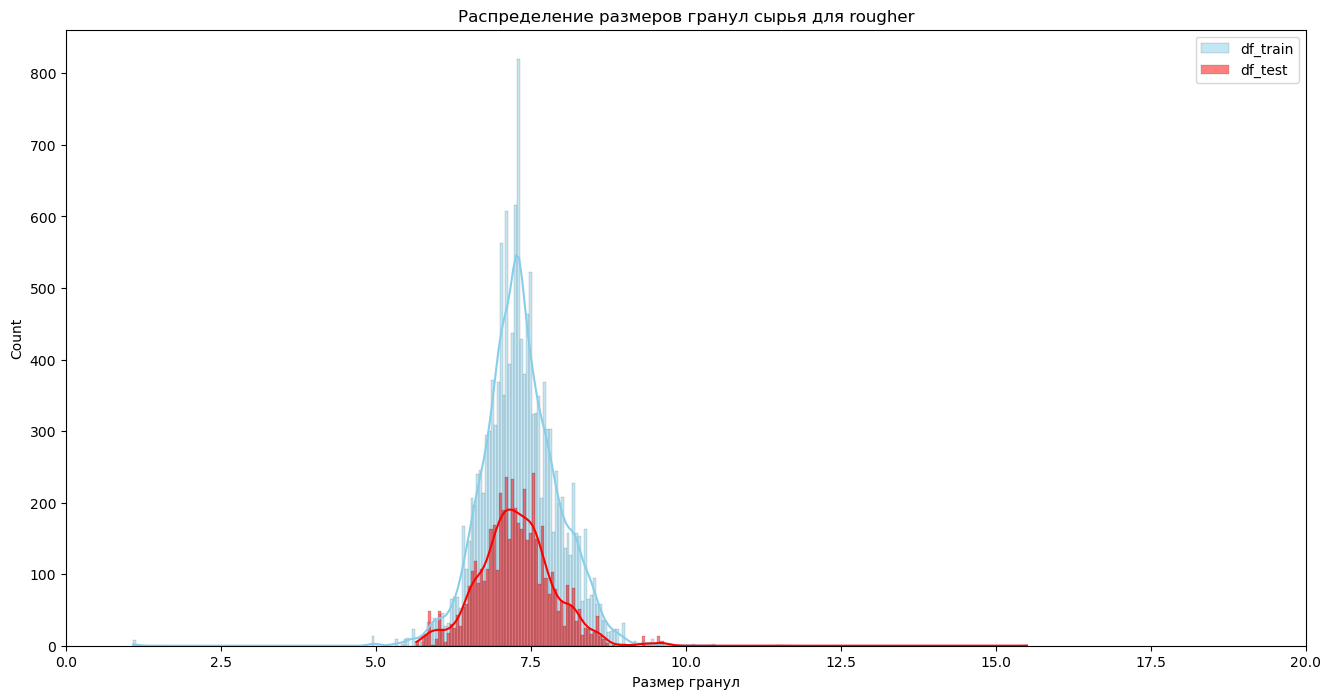

In [28]:
fig, ax = plt.subplots()
ax.set_title('Распределение размеров гранул сырья для primary_cleaner')
ax.set_xlabel('Размер гранул')
ax.set_xlim(0,20);

sns.histplot(data=df_train_selected_fill, x="primary_cleaner.input.feed_size", color="skyblue", label="df_train", kde=True, bins=200)
sns.histplot(data=df_test, x="primary_cleaner.input.feed_size", color="red", label="df_test", kde=True, bins=200)

fig.set_figheight(8)
fig.set_figwidth(16)
plt.legend() 
plt.show()

### Промежуточный вывод
- Распределения размеров гранул сырья для тестовой и обучающей выборок сопоставимы

## Исследуем суммарную концентрацию всех веществ на разных стадиях

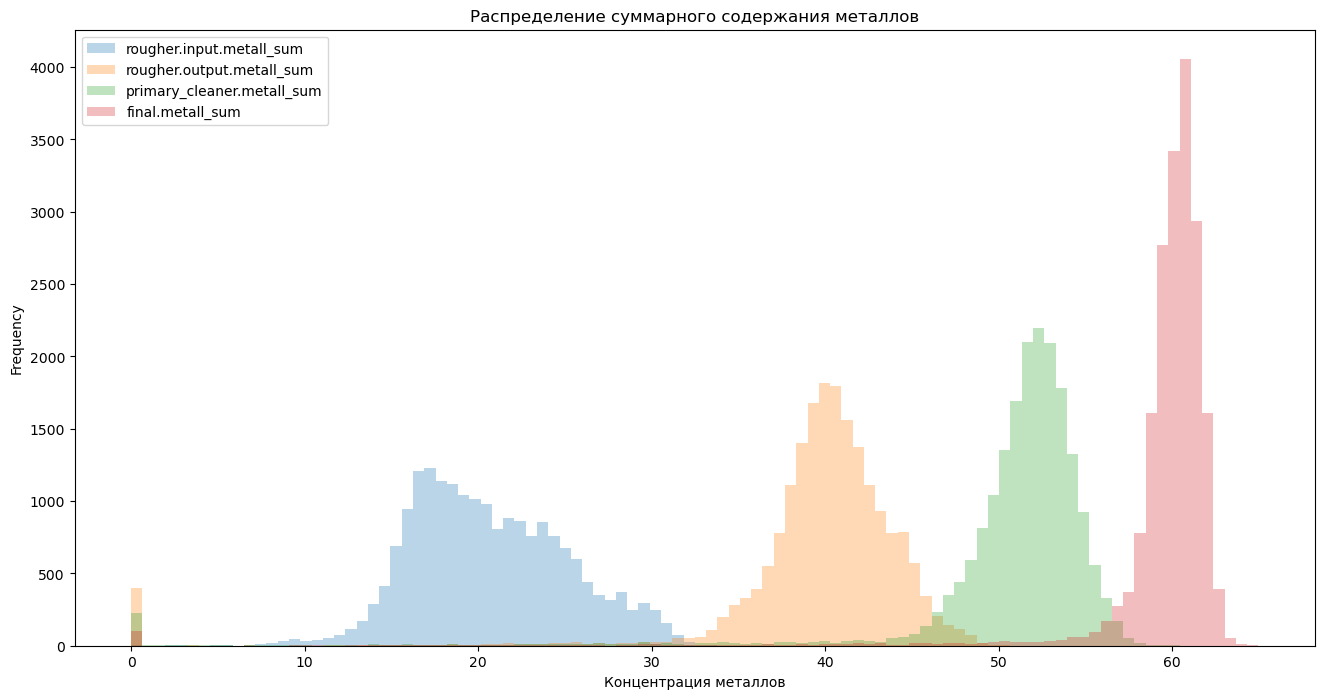

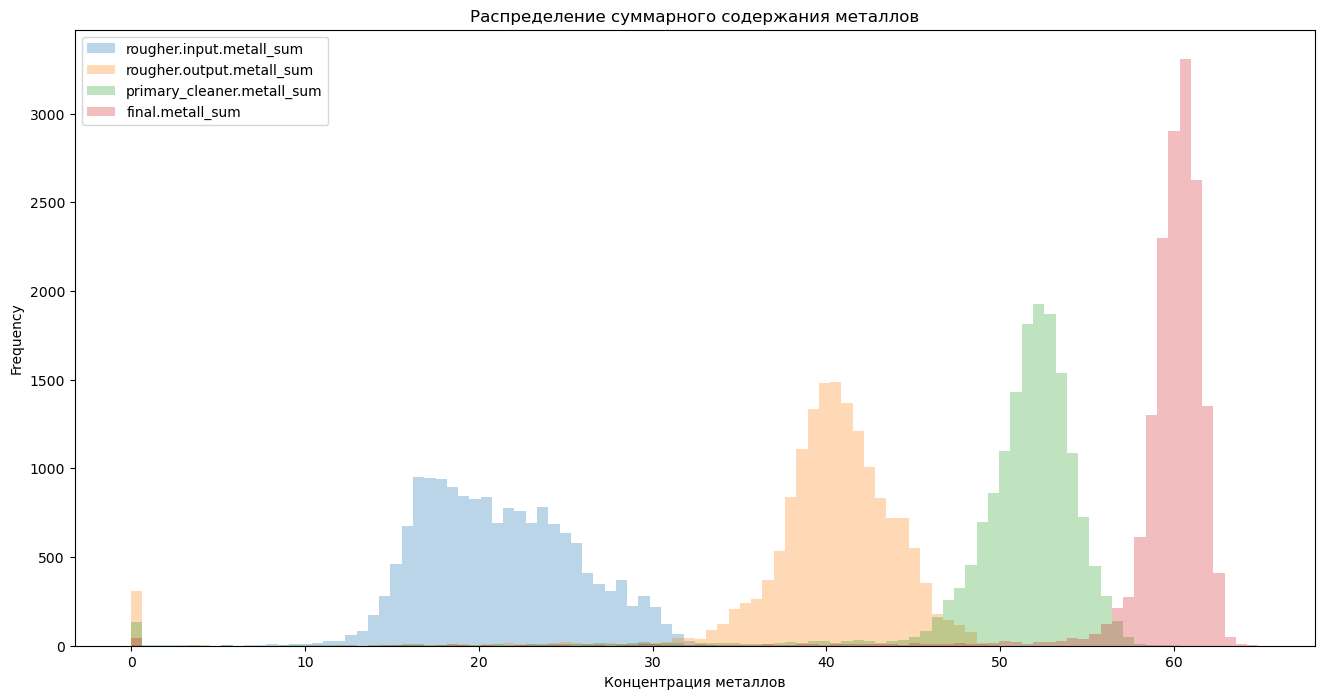

In [29]:
# Исследуем суммарную концентрацию всех веществ на разных стадиях
df_list = [df_full_fill, df_full_drop]
sum_fields = ['rougher.input.metall_sum','rougher.output.metall_sum', 'primary_cleaner.metall_sum', 'final.metall_sum']

for df in df_list:
    df['rougher.input.metall_sum'] = df['rougher.input.feed_ag'] + df['rougher.input.feed_au'] + df['rougher.input.feed_pb']
    df['rougher.output.metall_sum'] = df['rougher.output.concentrate_ag'] + df['rougher.output.concentrate_au'] + df['rougher.output.concentrate_pb']
    df['primary_cleaner.metall_sum'] = df['primary_cleaner.output.concentrate_ag'] + df['primary_cleaner.output.concentrate_au'] + df['primary_cleaner.output.concentrate_pb']
    df['final.metall_sum'] = df['final.output.concentrate_ag'] + df['final.output.concentrate_au'] + df['final.output.concentrate_pb']

    fig, ax = plt.subplots()
    ax.set_title('Распределение суммарного содержания металлов')
    ax.set_xlabel('Концентрация металлов')
    df[sum_fields].plot(kind='hist', bins=100, figsize=(16,8), ax=ax, legend=True, alpha=0.3);

### Промежуточный вывод
- Проанализовав два графика можно прийти к выводу, что нулевые выбросы сохранились. Это свидетельствует, что все слагаемые в замере равны нулю, следовательно нужно от них избавиться, удалив их из датасетов.
- Все три графика на каждой из трех стадий очитски концентрата похожи на нормальное распределение
- Количество анамалий и выбросов возрастает в выборке, где мы не удалили пропущенные значения. Это может говорить о природе их появляения. Возможно пропуски появились там где концентарция была слишком мала для её фиксации прибором.

Дальше будем работать с `df_full_fill`

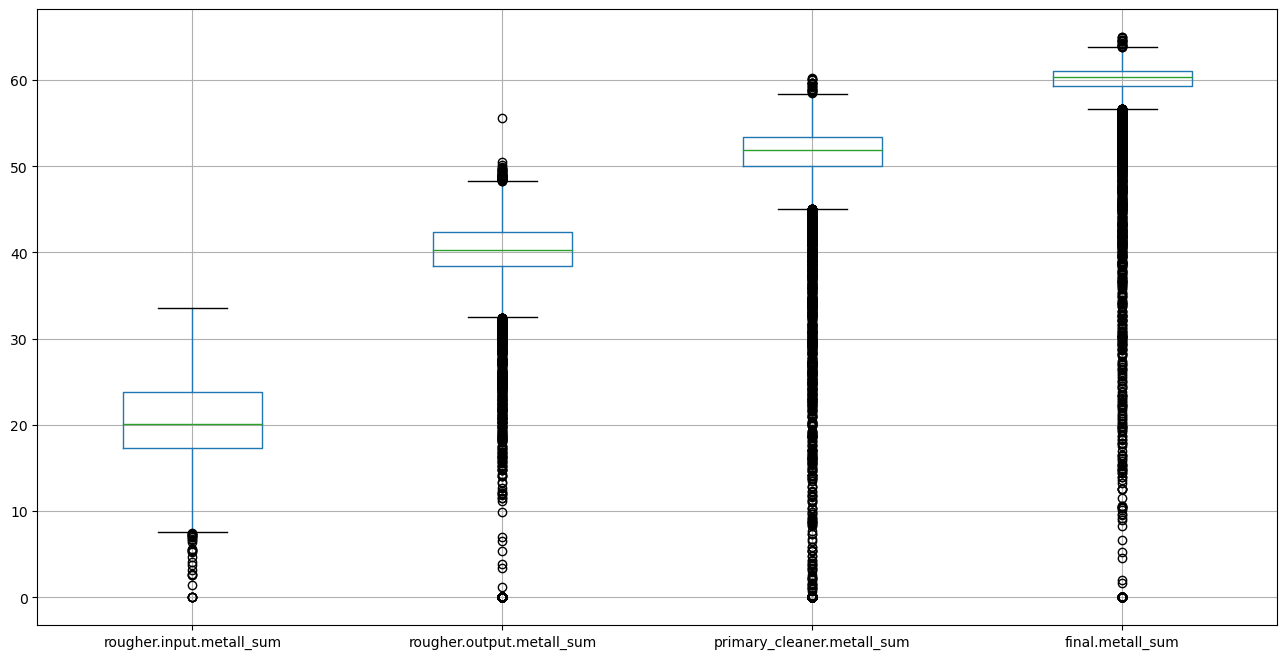

In [30]:
df_full_fill.boxplot(column=sum_fields, figsize=(16, 8));

In [31]:
len(df_full_fill) #sum_fields = ['rougher.input.metall_sum','rougher.output.metall_sum', 'primary_cleaner.metall_sum', 'final.metall_sum']

19439

In [32]:
df_full_fill = df_full_fill[(df_full_fill['rougher.output.metall_sum'] <= df_full_fill['rougher.output.metall_sum'].quantile(0.9999)) 
                            & (df_full_fill['rougher.output.metall_sum'] >= df_full_fill['rougher.output.metall_sum'].quantile(0.05))
                            &(df_full_fill['primary_cleaner.metall_sum'] <= df_full_fill['primary_cleaner.metall_sum'].quantile(0.9999)) 
                            & (df_full_fill['primary_cleaner.metall_sum'] >= df_full_fill['primary_cleaner.metall_sum'].quantile(0.07))
                            &(df_full_fill['final.metall_sum'] <= df_full_fill['final.metall_sum'].quantile(0.9999)) 
                            & (df_full_fill['final.metall_sum'] >= df_full_fill['final.metall_sum'].quantile(0.065))
                            &(df_full_fill['rougher.input.metall_sum'] <= df_full_fill['rougher.input.metall_sum'].quantile(0.9999))]

In [33]:
len(df_full_fill)

16528

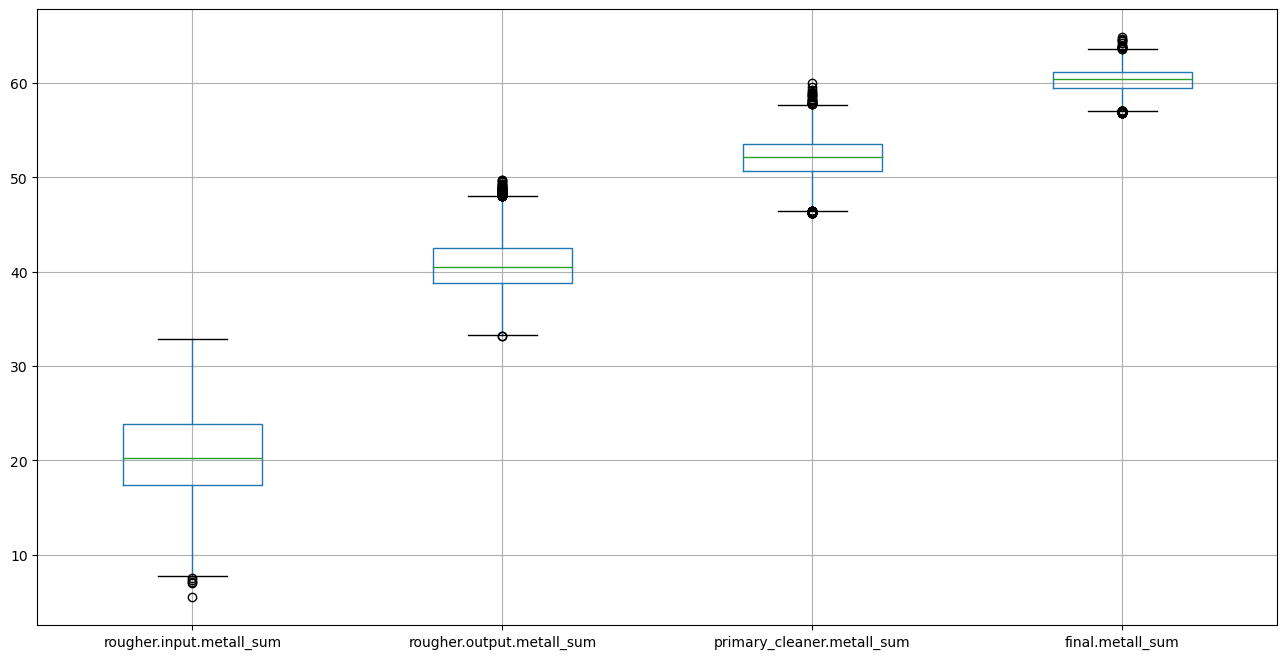

In [34]:
df_full_fill.boxplot(column=sum_fields, figsize=(16, 8));

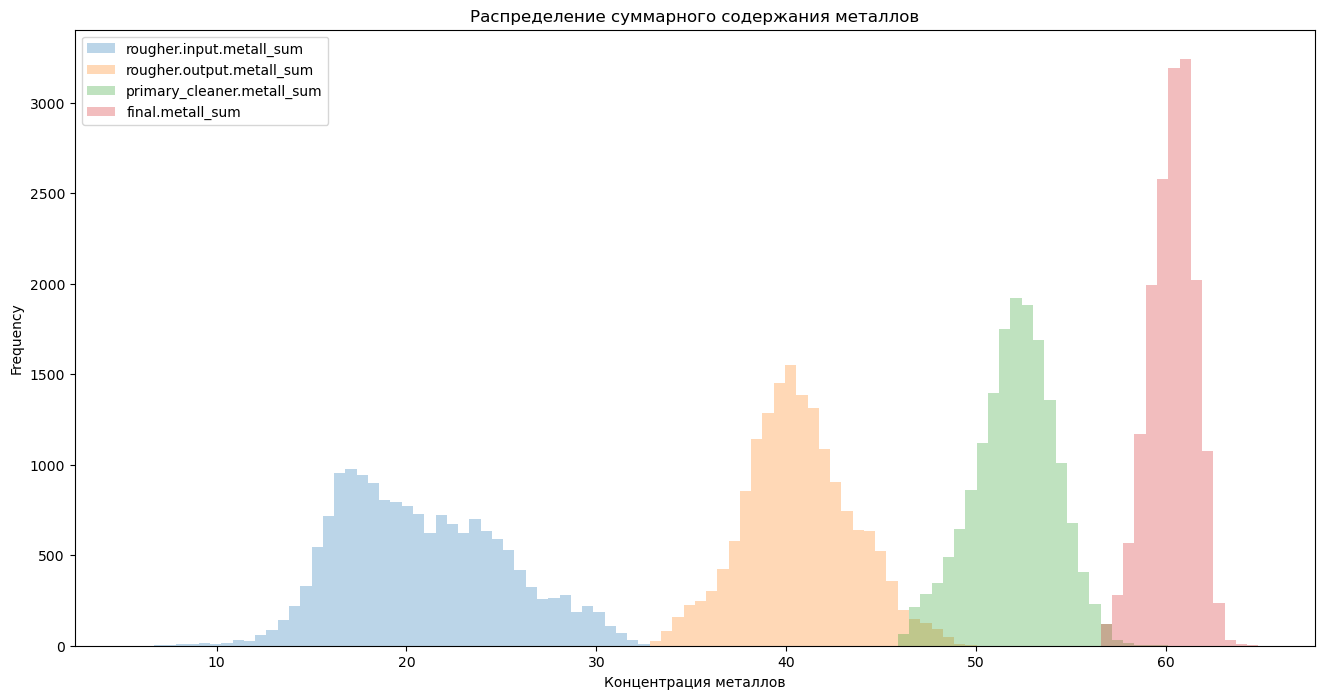

In [35]:
fig, ax = plt.subplots()
ax.set_title('Распределение суммарного содержания металлов')
ax.set_xlabel('Концентрация металлов')
df_full_fill[sum_fields].plot(kind='hist', bins=100, figsize=(16,8), ax=ax, legend=True, alpha=0.3);

In [36]:
# оставим в трейне соответствующие записи
df_train_selected_fill = df_train_selected_fill[df_train_selected_fill.index.isin(df_full_fill.index)]

df_test = df_test[df_test.index.isin(df_full_fill.index)]
df_test = df_test.dropna()

len(df_train_selected_fill)

11947

## Вывод по анализу данных

- Мы проанализировали наши данные и посмотрели как менятся концентрации металов на различных этапах очистки (золото и свинец растет, а серебро падает)
- Визуально оценили распределение размеров гранул в обучающей и тестовой выборке
- Исследовали суммарную концентрацию веществ на разных стадиях
- Удалили аномалии (правда с целью сохранить данные, сделали это в ограниченном варианте)

# Построение моделей

## Метрика качества
Для решения задачи введём новую метрику качества — **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

![title](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)

Нужно спрогнозировать сразу две величины:

- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика складывается из двух величин:

![title](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

In [37]:
# Напишем функцию для вычисления итоговой sMAPE
def smape(target, predicted):
    result = 0
    for key in range(0, len(predicted)):
        result += abs(target[key] - predicted[key]) / ((abs(target[key]) + abs(predicted[key])) / 2)
    result = (result / len(predicted)) * 100
    
    return result

In [38]:
def calculate_final_smape(target_rougher, predicted_rougher, target_final, predicted_final):
    return 0.25 * smape(target_rougher, predicted_rougher) + 0.75 * smape(target_final, predicted_final)

In [39]:
# нам нужны предсказания rougher.output.recovery и final.output.recovery, но в трейне их нет
df_target = df_full_fill[df_full_fill.index.isin(df_train_selected_fill.index)][['rougher.output.recovery', 'final.output.recovery']]
df_target.head()

,rougher.output.recovery,final.output.recovery
date,,
2016-01-15 00:00:00,87.107763,70.541216
2016-01-15 01:00:00,86.843261,69.266198
2016-01-15 02:00:00,86.842308,68.116445
2016-01-15 04:00:00,86.688794,66.927016
2016-01-15 05:00:00,88.156912,69.465816


In [40]:
# Аналогично получим таргет для теста
df_test_target = df_full_fill[df_full_fill.index.isin(df_test.index)][['rougher.output.recovery', 'final.output.recovery']]
df_test_target.head()

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078


### Промежуточный вывод
- По сути в нашем случае необходимо два признака, однако учить их на одинаковых параметрах не имеет смысла.
- Во-первых, на результат флотации не могут влиять значения "из будущего" в виде первичной очистки
- Во-вторых, для финального результата нет смысла опираться на флотацию (ее результаты пошли как раз в первую очистку)

Исходя из этого, нам понадобятся две разные модели и у них будут разные итоговые наборы признаков в рамках train выборки

In [41]:
rougher_columns = [
    'rougher.input.feed_ag',
    'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol',
    'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate',
    'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 
    'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
    'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 
    'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level'
]

# Тут по сути правильно смотреть только на результат второй очистки, т.к. результат первой дает как раз её
# Но входные параметры определяются также на первичной очистке, поэтому добавим также и их
final_columns = [
    'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 
    'primary_cleaner.input.xanthate','primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level',
    'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 
    'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level',
    'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level',
    
    'secondary_cleaner.state.floatbank2_a_air', 'secondary_cleaner.state.floatbank2_a_level',
    'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level',
    'secondary_cleaner.state.floatbank3_a_air', 'secondary_cleaner.state.floatbank3_a_level',
    'secondary_cleaner.state.floatbank3_b_air', 'secondary_cleaner.state.floatbank3_b_level',
    'secondary_cleaner.state.floatbank4_a_air', 'secondary_cleaner.state.floatbank4_a_level',
    'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank4_b_level',
    'secondary_cleaner.state.floatbank5_a_air', 'secondary_cleaner.state.floatbank5_a_level',
    'secondary_cleaner.state.floatbank5_b_air', 'secondary_cleaner.state.floatbank5_b_level',
    'secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank6_a_level'
]

In [42]:
df_rougher_train = df_train_selected_fill[rougher_columns]
df_rougher_target = df_target['rougher.output.recovery']

df_final_train = df_train_selected_fill[final_columns]
df_final_target = df_target['final.output.recovery']

df_rougher_train.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,...,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636
2016-01-15 01:00:00,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,...,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001
2016-01-15 02:00:00,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,...,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147
2016-01-15 04:00:00,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897,...,1600.208824,-449.599614,1600.357732,-450.034364,1599.759049,-449.909799,1401.560902,-448.877187,1401.160227,-450.407128
2016-01-15 05:00:00,5.801920,1.879351,546.173470,57.469578,35.470082,5.687168,11.072517,6.200383,11.075009,6.202362,...,1601.080554,-450.120760,1603.164805,-450.097732,1603.368371,-446.306150,1403.393100,-447.899904,1402.903175,-448.872321


## Промежуточный вывод
- В нашем случае мы имеем большое количество именно числовых признаков, исходя из чего дерево решений нам однозначно не подойдет, а случайный лес не позволит интерпретировать результаты вообще никак (что для цели оптимизации производства и запуска нового предприятия подходит плохо)

Тем не менее, задание требует обучить несколько моделей, поэтому попробуем и лес Для леса нам понадобится скалировать переменные

In [43]:
pd.set_option('mode.chained_assignment', None)
rougher_scaler = StandardScaler()
rougher_scaler.fit(df_rougher_train[rougher_columns])
df_rougher_train[rougher_columns] = rougher_scaler.transform(df_rougher_train[rougher_columns])

final_scaler = StandardScaler()
final_scaler.fit(df_final_train[final_columns])
df_final_train[final_columns] = final_scaler.transform(df_final_train[final_columns])


df_rougher_train.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,...,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,-1.355096,-1.177435,0.463133,-0.205937,0.048248,-0.786591,0.040187,0.108593,0.090323,0.131949,...,1.557574,0.524219,1.416046,0.415026,1.862358,0.256242,1.734413,0.169391,2.216130,0.227623
2016-01-15 01:00:00,-1.322153,-1.195228,0.480921,-0.128035,-0.185437,-0.790717,0.035272,0.106439,0.134442,0.137737,...,1.545062,0.255067,1.407089,0.276870,1.870034,0.280534,1.705973,0.251583,2.119515,0.260171
2016-01-15 02:00:00,-1.346376,-1.295519,0.529220,-0.117951,-0.137105,-0.854169,0.019149,0.292001,0.113449,0.301773,...,1.537204,0.254094,1.403277,0.274626,1.866760,0.280524,1.705723,0.268265,2.122983,0.252874
2016-01-15 04:00:00,-1.376500,-1.646828,0.636354,-0.181568,-0.496744,-1.235072,-0.287706,0.293405,-0.152167,0.293456,...,1.542036,0.261316,1.406514,0.273179,1.866324,0.281329,1.718628,0.287240,2.127882,0.255020
2016-01-15 05:00:00,-1.516976,-1.559671,0.693888,-0.119736,-0.248176,-1.222279,-0.251132,0.294912,-0.120483,0.299833,...,1.546869,0.252111,1.419778,0.272031,1.883744,0.346634,1.728563,0.304728,2.138005,0.282458


In [44]:
# Поскольку мы скалировали трейн, нужно аналогичным образом поступить и с тестом
df_test[rougher_columns] = rougher_scaler.transform(df_test[rougher_columns])
df_test[final_columns] = final_scaler.transform(df_test[final_columns])

In [45]:
# Попробуем обучить случайный лес, оценивать будем на флотации
my_scorer = make_scorer(smape, greater_is_better=False)

parameters = {'n_estimators': range(10,21,10),'max_depth': range(1,9,2), 'min_samples_leaf': range(1,7), 'min_samples_split': range(2,10,2)}

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, cv=5, scoring=my_scorer)
grid.fit(df_rougher_train, df_rougher_target)

grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 20}

In [58]:
# Посмотрим скоринг при лучших параметрах леса, найденных через GridSearchCV

RANDOM_STATE = 12345
model_forest = RandomForestRegressor(max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=20, random_state=RANDOM_STATE)

# Оценим модель кросс-валидацией
grid.best_score_*-1

5.901563930583995

In [59]:
cross_val_score(model_forest, df_rougher_train, df_rougher_target, cv=5, scoring=my_scorer).mean()*-1

5.947728821493842

In [60]:
model_lr = LinearRegression()

In [61]:
cross_val_score(model_lr, df_rougher_train, df_rougher_target, cv=5, scoring=my_scorer).mean()*-1

6.426214382345966

## Промежуточный вывод
 - К сожалению линейная регрессия на которую была возложена большая надежда уступила случайногому лесу.
 
Так или иначе модели были оценены методом кросс-валидации и дальше мы будем работать со случайным лесом.

In [62]:
# Посмотрим результат для флотации
model_forest.fit(df_rougher_train, df_rougher_target)
predicted_rougher = model_forest.predict(df_test[rougher_columns])

rougher_smape = smape(df_test_target['rougher.output.recovery'], predicted_rougher)
rougher_smape

4.167445709574548

In [63]:
# Проверим на final
model_forest.fit(df_final_train, df_final_target)
predicted_final = model_forest.predict(df_test[final_columns])
final_smape = smape(df_test_target['final.output.recovery'], predicted_final)
final_smape

11.930315035629215

In [64]:
# Посмотрим итоговую метрику для случайного леса
calculate_final_smape(df_test_target['rougher.output.recovery'], predicted_rougher, df_test_target['final.output.recovery'], predicted_final)

9.98959770411555

In [53]:
# проверим модель на адекватность
dummy = DummyRegressor(strategy="median")

In [54]:
cross_val_score(dummy, df_rougher_train, df_rougher_target, cv=5, scoring=my_scorer).mean()*-1

7.393148450108581

In [55]:
# Для этапа флотации
dummy.fit(df_rougher_train, df_rougher_target)
predicted_rougher = dummy.predict(df_test[rougher_columns])
rougher_smape_dummy = smape(df_test_target['rougher.output.recovery'], predicted_rougher)
rougher_smape_dummy

4.414892146922966

In [56]:
# Для финальных рассчетов
dummy.fit(df_final_train, df_final_target)
predicted_final = dummy.predict(df_test[final_columns])
final_smape_dummy = smape(df_test_target['final.output.recovery'], predicted_final)
final_smape_dummy

7.534677976363131

In [57]:
# Посмотрим итоговую метрику для случайного леса
calculate_final_smape(df_test_target['rougher.output.recovery'], predicted_rougher, df_test_target['final.output.recovery'], predicted_final)

6.75473151900309

# Вывод

Время подводить итоги проделанной работы:
- Мы изучили наши данные:
    - Проверили все три датафрейма их на дубликаты, разобрались с пропусками и выбросами.
    - Проверили корректность вычислений эффективности обогащения золота.
- Всячески пытались сохранить данные от выбрасывания, применяя связывание по времени.
- Провели серьезный анализ данных:
    - Рассмотрев вопросы изменения концентрации металов на разных этапах очистки.
    - Проверили и убедились, что распределения гранул сопоставимы.
    - Исследовали концентрацию веществ на разных стадиях фильтрации концентрата (на этом этапе мы как раз избавились от выбросов)

Итогом проведенной работы стала модель машинного обучения, выдающая наименьший(наилучший) результат ключевой метрики sMAPE и итоговой оценки. Такой моделью стал случайный лес с параметрами: max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=20.
